# Question Filtering Pipeline

EDIT corpus_id, set this to your corpus as named in /data/

In [17]:
import pandas as pd
questions_df = pd.read_csv('../data/questions_df.csv')

In [18]:
# Count the number of rows per 'corpus_id' group
grouped_df = questions_df.groupby('corpus_id').size()
print(grouped_df)

# Find the total number of rows in the dataframe
total_rows = questions_df.shape[0]
print("Total number of rows: ", total_rows)


corpus_id
chatlogs               83
finance               111
pubmed                112
state_of_the_union     95
wikitexts             208
dtype: int64
Total number of rows:  609


In [1]:
corpus_id = 'pubmed'

import pandas as pd

questions_df = pd.read_csv('../data/questions_df.csv')
questions_df = questions_df[questions_df['corpus_id'] == corpus_id]

print(len(questions_df))

164


In [2]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

def get_sim(target, references):
    response = client.embeddings.create(
        input=[target]+references,
        model="text-embedding-3-large"
    )
    cosine_similarities = []
    nparray1 = np.array(response.data[0].embedding)

    full_sim = []
    for i in range(1, len(response.data)):
        nparray2 = np.array(response.data[i].embedding)
        cosine_similarity = np.dot(nparray1, nparray2) / (np.linalg.norm(nparray1) * np.linalg.norm(nparray2))
        # full_sim.append((target, references[i-1], cosine_similarity))
        full_sim.append(cosine_similarity)
    # return np.mean(cosine_similarities)
    
    return full_sim

In [3]:
import json

# Apply json.loads directly to the 'references' column
questions_df['references'] = questions_df['references'].apply(json.loads)


In [4]:
# Define the function to edit each row
def edit_row(row):
    question = row['question']
    references = [ref['content'] for ref in row['references']]
    similarity_scores = get_sim(question, references)
    worst_ref_score = min(similarity_scores)
    row['worst_ref_score'] = worst_ref_score
    return row

# Apply the function to each row
questions_df = questions_df.apply(edit_row, axis=1)


Mean:  0.5651221544328768
Standard Deviation: 0.14139233068958812
Median: 0.5625570385353631
Top 75%: 0.6821199869141636
Bottom 25%: 0.45266472801166796


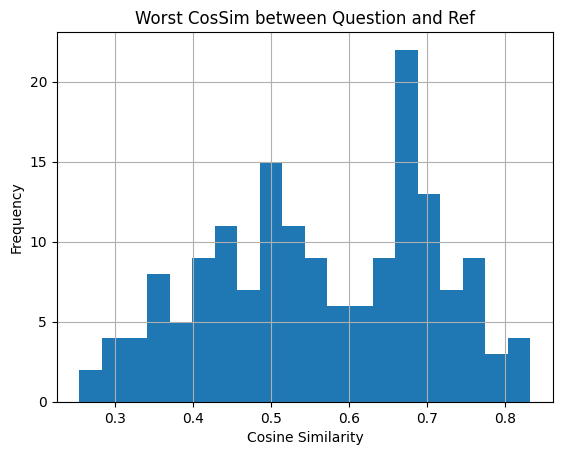

In [5]:
import matplotlib.pyplot as plt

cosine_scores = questions_df['worst_ref_score'].values
print("Mean: ", cosine_scores.mean())
print("Standard Deviation:", np.std(cosine_scores))
print("Median:", np.median(cosine_scores))
print("Top 75%:", np.percentile(cosine_scores, 75))
print("Bottom 25%:", np.percentile(cosine_scores, 25))

plt.hist(cosine_scores, bins=20)
plt.title('Worst CosSim between Question and Ref')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

EDIT threshold, set this to some value and see text given below. Change it until you're happy with outputs.

In [6]:
# Test threshold:
threshold = 0.36

print("Number of questions with worst CosSim below threshold:", len(questions_df[questions_df['worst_ref_score'] < threshold]))
# Remove questions with worst CosSim below threshold
filtered_questions_df = questions_df[questions_df['worst_ref_score'] >= threshold]

# Calculate the percentage of questions removed
percentage_removed = (len(questions_df) - len(filtered_questions_df)) / len(questions_df) * 100

# Print the results
print("Percentage of questions removed:", percentage_removed)
print("Number of questions left:", len(filtered_questions_df))

# Add a new column to the dataframe for the absolute difference between the worst_ref_score and the threshold
questions_df['score_diff'] = abs(questions_df['worst_ref_score'] - threshold)

# Print out the 3 questions closest to the threshold from below and their references
print("3 questions closest to the threshold from below and their references:")
for _, row in questions_df[questions_df['worst_ref_score'] < threshold].nsmallest(3, 'score_diff').iterrows():
    print("Question:", row['question'])
    print("References:", row['references'])
    print()

# Print out the 3 questions closest to the threshold from above and their references
print("\n3 questions closest to the threshold from above and their references:")
for _, row in questions_df[questions_df['worst_ref_score'] >= threshold].nsmallest(3, 'score_diff').iterrows():
    print("Question:", row['question'])
    print("References:", row['references'])
    print()

Number of questions with worst CosSim below threshold: 15
Percentage of questions removed: 9.146341463414634
Number of questions left: 149
3 questions closest to the threshold from below and their references:
Question: What factors indicate the similarity between the expression profiles of known vaccine candidates and the rest of the IDC transcriptome?
References: [{'content': 'To identify ORFs with a possible involvement in the merozoite invasion process, we have calculated the similarity, by Euclidian distance, between the expression profiles of these seven vaccine candidates and the rest of the IDC transcriptome', 'start_index': 52541, 'end_index': 52782}, {'content': 'A histogram of the distance values reveals a bimodal distribution with 262 ORFs in the first peak of the distribution (Figure S4)', 'start_index': 52784, 'end_index': 52913}, {'content': 'This represents the top 5% of expression profiles when ranked by increasing Euclidian distance (Table S7)', 'start_index': 52915, '

# Make Reference Cut

In [7]:
questions_df = questions_df[questions_df['worst_ref_score'] >= threshold]
questions_df = questions_df.drop(columns=['score_diff', 'worst_ref_score'])

In [8]:
print(len(questions_df))
# Remove duplicates from the questions dataframe
questions_df.drop_duplicates(subset='question', keep='first', inplace=True)
print(len(questions_df))

149
149


In [9]:
questions = questions_df['question'].tolist()

In [10]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

response = client.embeddings.create(
    input=questions,
    model="text-embedding-3-large"
)

0.6854248318847395


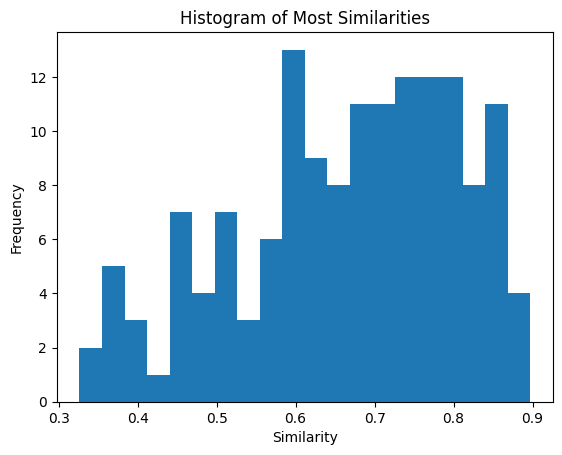

In [11]:
embeddings_matrix = np.array([data.embedding for data in response.data])

dot_product_matrix = np.dot(embeddings_matrix, embeddings_matrix.T)

# Create a list of tuples containing the index pairs and their similarity
similarity_pairs = [(i, j, dot_product_matrix[i][j]) for i in range(len(dot_product_matrix)) for j in range(i+1, len(dot_product_matrix))]

# Sort the list of tuples based on the similarity in descending order
similarity_pairs.sort(key=lambda x: x[2], reverse=True)

similarity_scores = np.array([x[2] for x in similarity_pairs])

most_similars = (dot_product_matrix - np.eye(dot_product_matrix.shape[0])).max(axis=1)

print(np.median(most_similars))

import matplotlib.pyplot as plt

# Assuming most_similars is a numpy array
plt.hist(most_similars, bins=20)
plt.title('Histogram of Most Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

EDIT threshold, then check output below. Keep changing until you're happy with outputs.

In [14]:
# threshold = 0.78
threshold = 0.71

def filter_vectors(sim_matrix, threshold):
    n = sim_matrix.shape[0]  # Number of vectors
    remaining = np.ones(n, dtype=bool)  # Initialize all vectors as remaining

    for i in range(n):
        if remaining[i] == 1:  # Only check for vectors that are still remaining
            for j in range(i+1, n):
                if remaining[j] == 1 and sim_matrix[i, j] > threshold:
                    remaining[j] = 0  # Remove vector j because it's too similar to vector i
    
    return remaining

rows_to_keep = filter_vectors(dot_product_matrix, threshold)

# Find the index of the threshold in the similarity_scores array
# Since threshold is a decimal, we use np.isclose to find the index
# As per the followup instructions, we find the one with the smallest distance
threshold_index = np.argmin(np.abs(similarity_scores - threshold))

print(f"Similarity Threshold: {threshold}")

print(f"Number of questions cut: {len(rows_to_keep) - rows_to_keep.sum()}")
print(f"Number of questions left: {rows_to_keep.sum()}")

print("Questions about threshold:")
for i in range(threshold_index-4, threshold_index+6):
    first_index, second_index, sim = similarity_pairs[i]
    print(questions[first_index])
    print(questions[second_index])
    print(sim)
    print("------\n")
    if i == threshold_index:
        print("---Threshold---")

Similarity Threshold: 0.71
Number of questions cut: 37
Number of questions left: 112
Questions about threshold:
How does the control of axin degradation impact β-catenin levels?
What is the effect of Wnt stimulation on the steady-state concentrations of β-catenin and axin?
0.716157500049333
------

What components are needed for V(D)J recombination as detailed in the PubMed texts?
What are the conserved components of the recombination signal sequences (RSSs) as described in the PubMed text?
0.7155023322839321
------

What are the effects of varying APC concentrations on β-catenin degradation?
What are the described effects of changing total concentrations of pathway components on β-catenin and axin?
0.7145530831707396
------

How are ARF and PLD activated by insulin according to the research?
How does wild type ARNO influence ARF translocation and PLD activity in response to insulin?
0.7133884842861715
------

How does the rrf-3 strain affect the detection of postembryonic mutant pheno

# Make the cut

In [15]:
questions_df = questions_df[rows_to_keep]

# Save edited questions

In [16]:

questions_df['references'] = questions_df['references'].apply(json.dumps)

full_questions_df = pd.read_csv('../data/questions_df.csv')
full_questions_df = full_questions_df[full_questions_df['corpus_id'] != corpus_id]
# edited_rows_df = pd.read_csv('../data/edited_rows_df.csv')
full_questions_df = pd.concat([full_questions_df, questions_df], ignore_index=True)
# Drop the columns 'fixed', 'worst_ref_score' and 'diff_score' if they exist
for col in ['fixed', 'worst_ref_score', 'diff_score']:
    if col in full_questions_df.columns:
        full_questions_df = full_questions_df.drop(columns=col)

full_questions_df.to_csv('../data/questions_df.csv', index=False)
